# fastTextによる分類

[fastText](https://fasttext.cc/)
は分類器の学習もサポートしていており、単語埋め込みも含めて学習することで精度の向上が期待できます。

```{note}
fastTextを使うためには事前にfasttextパッケージをインストールしておきます。

    !pip install fasttext==0.9.1
```

**データのロード**

In [1]:
import pandas as pd
from sklearn import model_selection

data = pd.read_csv("input/pn_same_judge_preprocessed.csv")
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=0)

## ラベルの準備

fastTextが必要とするラベルを付与します。

In [2]:
def apply_fn(row):
    tokens = row["tokens"]
    label = f"__label__{row['label_num']}"
    return f"{label} {tokens}"

In [3]:
for target in [train, test]:
    target["model_input"] = target.apply(apply_fn, axis="columns")

In [4]:
train.head(n=3)

,text,label_num,tokens,model_input
2310,また利用したいホテルである。,0,また 利用 する たい ホテル だ ある 。,__label__0 また 利用 する たい ホテル だ ある 。
308,お腹いっぱい食べてしまいました。,0,お腹 いっぱい 食べる て しまう ます た 。,__label__0 お腹 いっぱい 食べる て しまう ます た 。
684,とにかく狭い。,1,とにかく 狭い 。,__label__1 とにかく 狭い 。


In [5]:
test.head(n=3)

,text,label_num,tokens,model_input
3574,当日貸切状態で、最高の部屋を用意していただきました。,0,当日 貸切 状態 で 、 最高 の 部屋 を 用意 する て いただく ます た 。,__label__0 当日 貸切 状態 で 、 最高 の 部屋 を 用意 する て いただく...
1386,マタニティ旅行で利用しました。,0,マタニティ 旅行 で 利用 する ます た 。,__label__0 マタニティ 旅行 で 利用 する ます た 。
499,コンビニも近いです。,0,コンビニ も 近い です 。,__label__0 コンビニ も 近い です 。


ファイルに保存します。

In [6]:
train[["model_input"]].to_csv("input/pn_ft_train.csv", header=None, index=None)
test[["model_input"]].to_csv("input/pn_ft_test.csv", header=None, index=None)

In [7]:
!head -n3 input/pn_ft_train.csv

__label__0 また 利用 する たい ホテル だ ある 。
__label__0 お腹 いっぱい 食べる て しまう ます た 。
__label__1 とにかく 狭い 。


In [8]:
!head -n3 input/pn_ft_test.csv

__label__0 当日 貸切 状態 で 、 最高 の 部屋 を 用意 する て いただく ます た 。
__label__0 マタニティ 旅行 で 利用 する ます た 。
__label__0 コンビニ も 近い です 。


## 学習する

In [9]:
import fasttext

model = fasttext.train_supervised(input="input/pn_ft_train.csv")

Read 0M words
Number of words:  3075
Number of labels: 2
Progress: 100.0% words/sec/thread: 1201377 lr:  0.000000 loss:  0.212663 ETA:   0h 0m


In [10]:
model.test("input/pn_ft_test.csv")

(419, 0.9093078758949881, 0.9093078758949881)

In [11]:
def prob_fn(item):
    input_text = " ".join(item.split()[1:])
    pred = model.predict(input_text)
    label = pred[0][0]
    score = pred[1][0]
    if label == "__label__1":
        pass
    elif label == "__label__0":
        score = 1 - score
    else:
        raise Exception(f"Label is not expected one: {label}")
    label_map = {"__label__1": 1, "__label__0": 0}
    return label_map[label], score

pred = test["model_input"].apply(lambda x: prob_fn(x)[0])
score = test["model_input"].apply(lambda x: prob_fn(x)[1])

In [12]:
pred.head()

3574    0
1386    0
499     0
3756    0
914     0
Name: model_input, dtype: int64

In [13]:
score.head()

3574    0.017346
1386    0.000513
499     0.006268
3756    0.018718
914     0.019504
Name: model_input, dtype: float64

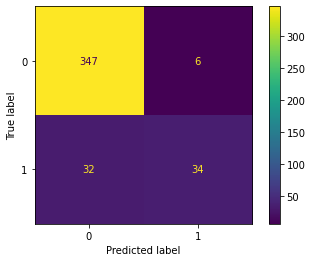

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true=test["label_num"], y_pred=pred)

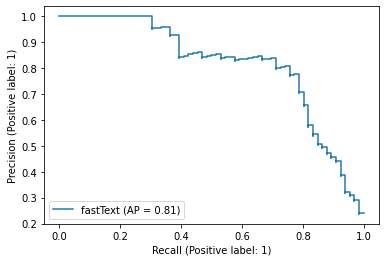

In [15]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(y_true=test["label_num"], y_pred=score, name="fastText")